## Data loader testing

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('../')
print(os.getcwd())

/home/yyjau/Documents/deepSfm_test


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def loadConfig(filename):
    import yaml
    with open(filename, 'r') as f:
        config = yaml.load(f)
    return config


In [4]:
# load config
logging.basicConfig(format='[%(asctime)s %(levelname)s] %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)

%env TMPDIR=tmp/
# filename = 'configs/magicpoint_kitti_train.yaml'
# filename = 'configs/superpoint_coco_train_heatmap.yaml'
# filename = 'configs/superpoint_kitti_train_heatmap.yaml'
# filename = 'configs/magicpoint_coco_export.yaml'
# filename = 'configs/magicpoint_shapes.yaml'
# filename = 'configs/magicpoint_shapes_pair.yaml'
filename = 'configs/magicpoint_repeatability_heatmap.yaml'
config = loadConfig(filename)
print("config: ", config)

env: TMPDIR=tmp/
config:  {'data': {'name': 'patches_dataset', 'dataset': 'hpatches', 'alteration': 'all', 'preprocessing': {'resize': [240, 320]}}, 'front_end_model': 'Val_model_heatmap', 'model': {'name': 'SuperPointNet_gauss2', 'params': {}, 'detection_threshold': 0.015, 'batch_size': 1, 'eval_batch_size': 1, 'learning_rate': 0.001, 'nms': 4, 'top_k': 1000, 'nn_thresh': 1.0, 'homography_adaptation': {'num': 0}, 'subpixel': {'enable': True, 'patch_size': 5}, 'rand_noise': {'enable': False, 'sigma': 0.2}, 'pretrained': 'logs/superpoint_coco/checkpoints/superPointNet_180_checkpoint.pth.tar'}, 'eval_iter': 1000}


/home/yyjau/anaconda3/envs/py36-sp/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


In [8]:
## test set
from utils.loader import dataLoader_test as dataLoader
task = config['data']['dataset']
data = dataLoader(config, dataset=task)
test_set, test_loader = data['test_set'], data['test_loader']
print(f"{len(test_set)}")

580


In [6]:
from utils.loader import dataLoader
task = config['data']['dataset']
print("task: ", task)
data = dataLoader(config, dataset=task, warp_input=True)

# data
train_loader, val_loader = data['train_loader'], data['val_loader']

logging.info('== train split size %d in %d batches, val split size %d in %d batches'%\
        (len(train_loader)*config['model']['batch_size'], len(train_loader),
         len(val_loader)*config['model']['batch_size'], len(val_loader)))



task:  hpatches


ModuleNotFoundError: No module named 'datasets.hpatches'

In [17]:
# val
# for i, sample in enumerate(val_loader):
#     if i > 1:
#         print(list(sample))
#         break
# train
print("load training samples")
for i, sample in enumerate(train_loader):
    if i > 1:
        print(list(sample))
        break


load training samples
['image', 'valid_mask', 'labels_2D', 'labels_res', 'warped_labels_gaussian', 'warped_labels_bi', 'warped_img', 'warped_labels', 'warped_res', 'warped_valid_mask', 'homographies', 'inv_homographies', 'labels_2D_gaussian', 'name']


In [118]:
from datasets.data_tools import np_to_tensor

## train set (not loader)

In [8]:
train_set = data['train_set']
sample = train_set[0]

/home/yoyee/Documents/deepSfm/datasets/SyntheticDataset_gaussian.py:410: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  warped_img = torch.tensor(img, dtype=torch.float32)
/home/yoyee/Documents/deepSfm/datasets/data_tools.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pnts = torch.tensor(pnts).long() ### check


In [9]:
def unsqueeze_dict(sample, dim=0):
    for i in list(sample):
        if type(element) is torch.Tensor:
            sample[i] = sample[i].unsqueeze(dim)
unsqueeze_dict(sample, dim=0)

NameError: name 'element' is not defined

## visualize data

In [19]:
import torch

In [20]:
# print shape
entries = list(sample)
for i in entries:
    element = sample[i]
#     print(type(element))
    if type(element) is torch.Tensor:
        print("shape of ", i, " ", element.shape)
img, labels_2D, mask_2D = sample['image'], sample['labels_2D'], sample['valid_mask']


shape of  image   torch.Size([4, 1, 384, 1248])
shape of  valid_mask   torch.Size([4, 1, 384, 1248])
shape of  labels_2D   torch.Size([4, 1, 384, 1248])
shape of  labels_res   torch.Size([4, 2, 384, 1248])
shape of  warped_labels_gaussian   torch.Size([4, 1, 384, 1248])
shape of  warped_labels_bi   torch.Size([4, 1, 384, 1248])
shape of  warped_img   torch.Size([4, 1, 384, 1248])
shape of  warped_labels   torch.Size([4, 1, 384, 1248])
shape of  warped_res   torch.Size([4, 2, 384, 1248])
shape of  warped_valid_mask   torch.Size([4, 1, 384, 1248])
shape of  homographies   torch.Size([4, 3, 3])
shape of  inv_homographies   torch.Size([4, 3, 3])
shape of  labels_2D_gaussian   torch.Size([4, 1, 384, 1248])


In [21]:
sample['labels_2D_gaussian'].dtype

torch.float32

(384, 1248, 3)


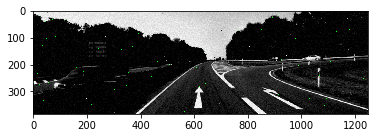

In [22]:
def img_overlap(img_r, img_g, img_gray):  # img_b repeat
    img = np.concatenate((img_gray, img_gray, img_gray), axis=0)
    img[0, :, :] += img_r[0, :, :]
    img[1, :, :] += img_g[0, :, :]
    img[img > 1] = 1
    img[img < 0] = 0
    img = img.transpose([1,2,0])
    return img
def toNumpy(tensor):
    return tensor.detach().cpu().numpy()

result_overlap = img_overlap(toNumpy(1 - mask_2D[0,:,:,:]), toNumpy(labels_2D[0, :, :, :]), toNumpy(img[0, :, :, :]))
print(result_overlap.shape)

plt.imshow(result_overlap)
plt.show()

## Test gaussian

gaussian:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
kernel size:  0.2


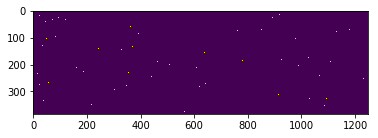

In [25]:
# gauss_map = sample['warped_labels_gaussian']
# gauss_map = sample['warped_labels_gaussian']
# gauss_map = sample['warped_labels']
gauss_map = sample['labels_2D_gaussian']

    
plt.imshow(toNumpy(gauss_map[0,0,:,:]))
print("gaussian: ", toNumpy(gauss_map[0,0,:,:]))
print("kernel size: ", config['data']['gaussian_label']['params']['GaussianBlur']['sigma'])
plt.show()

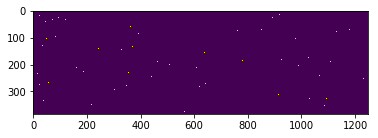

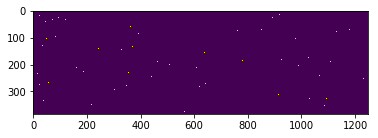

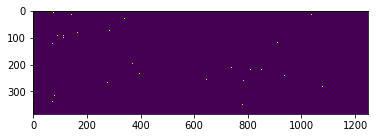

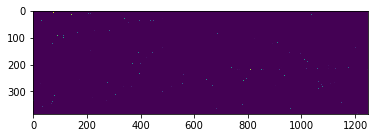

In [26]:
# gauss_map = sample['labels_2D'] # - sample['warped_labels_bi']
maps = ['labels_2D', 'labels_2D_gaussian', 'warped_labels', 'warped_labels_gaussian']

for m in maps:
    gauss_map = sample[m]
    plt.imshow(toNumpy(gauss_map[0,0,:,:]))
    plt.show()

gaussian:  0.28627452


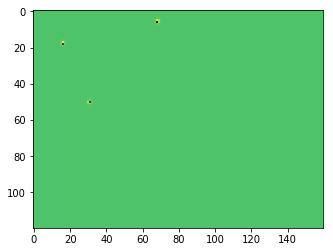

In [62]:
# gauss_map = sample['warped_labels_gaussian'] - sample['warped_labels']
gauss_map = sample['labels_2D_gaussian'] - sample['labels_2D']
# gauss_map = sample['warped_labels']

plt.imshow(toNumpy(gauss_map[0,0,:,:]))
print("gaussian: ", toNumpy(gauss_map[0,0,:,:]).max())
# print("kernel size: ", config['data']['gaussian_label']['sigma'])
plt.show()

gaussian:  2.0


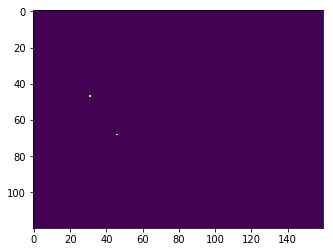

In [58]:
from utils.utils import inv_warp_image_batch
labels_unwarp = inv_warp_image_batch(sample['warped_labels'], sample['homographies'], mode = 'nearest')
# labels_unwarp = inv_warp_image_batch(sample['warped_labels_bi'], sample['homographies'], mode = 'nearest')
# gauss_map = labels_unwarp - sample['labels_2D']
# gauss_map = sample['labels_2D'] - labels_unwarp
gauss_map = labels_unwarp
# gauss_map = sample['warped_labels']

plt.imshow(toNumpy(gauss_map[0,0,:,:]))
print("gaussian: ", toNumpy(gauss_map[0,0,:,:]).sum())
# print("kernel size: ", config['data']['gaussian_label']['sigma'])
plt.show()

gaussian:  -1.0


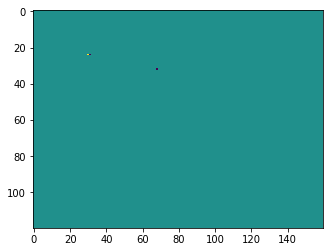

In [60]:
labels_ununwarp = inv_warp_image_batch(labels_unwarp, sample['inv_homographies'], mode = 'nearest')
# labels_unwarp = inv_warp_image_batch(sample['warped_labels_bi'], sample['homographies'], mode = 'nearest')
# gauss_map = labels_unwarp - sample['labels_2D']
# gauss_map = sample['labels_2D'] - labels_unwarp
gauss_map = labels_ununwarp - sample['warped_labels']
# gauss_map = sample['warped_labels']

plt.imshow(toNumpy(gauss_map[0,0,:,:]))
print("gaussian: ", toNumpy(gauss_map[0,0,:,:]).sum())
# print("kernel size: ", config['data']['gaussian_label']['sigma'])
plt.show()

## check gt patches prediction

In [27]:
device='cuda:0'

In [28]:
# uses labels_2D, heatmap
# heatmap = gauss_map
to_floatTensor = lambda x: torch.tensor(x).type(torch.FloatTensor)

# for synthetic data
def get_data(mode='coco'):
    global labels_2D, heatmap
    if mode == 'coco':
        labels_2D = to_floatTensor(sample['warped_labels'])
        heatmap = to_floatTensor(sample['warped_labels_gaussian'])        
#         heatmap = to_floatTensor(sample['warped_labels_bi'])        
    else:
        labels_2D = to_floatTensor(sample['labels_2D'])
        heatmap = to_floatTensor(sample['labels_2D_gaussian'])
    
        
get_data(mode='coco')
## crop patches from labels map
from utils.losses import pts_to_bbox
from utils.losses import _roi_pool

patch_size=5
points = labels_2D[...].nonzero()
rois = pts_to_bbox(points[:,2:], patch_size=patch_size)
rois = torch.cat((points[:,:1], rois), dim=1)
print("heatmap: ", heatmap.dtype)
print("heatmap: ", heatmap.max())
print("rois: ", rois.dtype)
patches = _roi_pool(heatmap.to(device), rois.to(device), patch_size=patch_size)
print("patches: ", patches.shape)
## softargmax

/home/yoyee/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


heatmap:  torch.float32
heatmap:  tensor(1.)
rois:  torch.int64
patches:  torch.Size([1744, 1, 5, 5])


In [29]:
## norm the patches
import torch.nn as nn
def norm_patches(patches):
    patches = patches.view(-1, 1, patch_size*patch_size)
    d = torch.sum(patches, dim=-1).unsqueeze(-1) + 1e-6
    patches = patches/d
    patches = patches.view(-1, 1, patch_size, patch_size)
    print("patches: ", patches.shape)
    return patches

patches = norm_patches(patches)


patches:  torch.Size([1744, 1, 5, 5])


patches[img_id,0,:,:] max:  0.50592834
patches[img_id,0,:,:] sum:  0.9999989


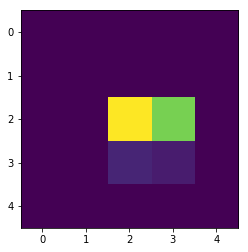

patches[img_id,0,:,:] max:  0.52173865
patches[img_id,0,:,:] sum:  0.999999


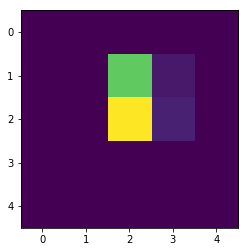

patches[img_id,0,:,:] max:  0.59683734
patches[img_id,0,:,:] sum:  0.9999989


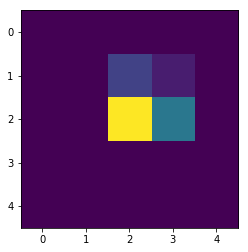

patches[img_id,0,:,:] max:  0.6205528
patches[img_id,0,:,:] sum:  0.99999905


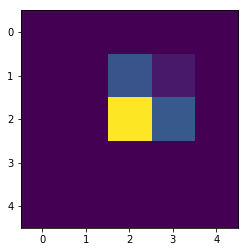

patches[img_id,0,:,:] max:  0.9169951
patches[img_id,0,:,:] sum:  0.9999989


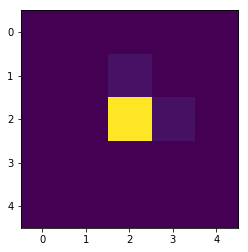

patches[img_id,0,:,:] max:  0.59126925
patches[img_id,0,:,:] sum:  0.999999


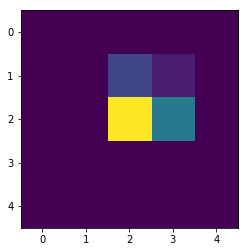

patches[img_id,0,:,:] max:  0.5118105
patches[img_id,0,:,:] sum:  0.9999989


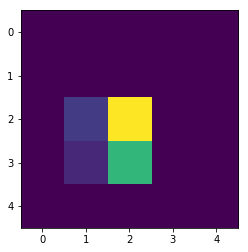

patches[img_id,0,:,:] max:  0.71428496
patches[img_id,0,:,:] sum:  0.999999


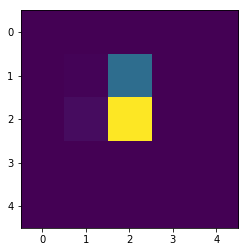

patches[img_id,0,:,:] max:  0.6837938
patches[img_id,0,:,:] sum:  0.999999


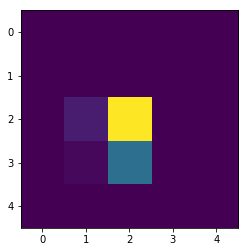

patches[img_id,0,:,:] max:  0.3517783
patches[img_id,0,:,:] sum:  0.9999989


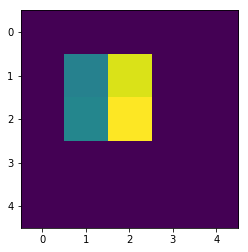

In [30]:
# print patches
def draw_center(patch, pos):
    patch[...,pos,pos] = 1
    return patch

from utils.var_dim import toNumpy

for i in range(10):
    img_id = i
#     print("res (x, y): ", points_res[i])
#     plt.imshow(draw_center(toNumpy(patches[img_id,0,:,:]), 4))
    p = toNumpy(patches[img_id,0,:,:])
    plt.imshow(p)
#     print("patches[img_id,0,:,:]: ", p)
    print("patches[img_id,0,:,:] max: ", p.max())
    print("patches[img_id,0,:,:] sum: ", p.sum())
    plt.show()

In [31]:
labels_warped_res = sample['warped_res']
print("labels_warped_res: ", labels_warped_res.shape)
# labels_warped_res = sample['warped_labels']
# labels_warped_res = sample['labels_res']

def ext_from_points(labels_res, points):
    labels_res = labels_res.transpose(1,2).transpose(2,3).unsqueeze(1)
    points_res = labels_res[points[:,0],points[:,1],points[:,2],points[:,3],:]  # tensor [N, 2]
    return points_res
    
points_res = ext_from_points(labels_warped_res, points)
print("points_res: ", points_res.shape)

# points_res = label_to_points(labels_warped, points)
# print("labels_warped: ", points_res.shape)

labels_warped_res:  torch.Size([4, 2, 384, 1248])
points_res:  torch.Size([1744, 2])


In [32]:
## log on patches
def do_log(patches):
    patches[patches==0] = patches[patches==0] + 1e-6
    patches_log = torch.log(patches)
    return patches_log

# patches_log = do_log(patches)
patches_log = do_log(patches)
# patches_log = patches


In [33]:
from utils.losses import soft_argmax_2d
## point residual
print("points_res: ", points_res.shape)
print("points_res: ", points_res[:10])
# print("points_res sum: ", points_res.sum())

## no norm
dxdy = soft_argmax_2d(patches_log, normalized_coordinates=False) # tensor [B, N, patch, patch]
dxdy = dxdy.squeeze(1) # tensor [N, 2]
dxdy = dxdy-patch_size//2
print("dxdy: ", dxdy.shape)
print("dxdy: ", dxdy[:10])
num = 500
print("errors: ", abs(dxdy[:num].cpu() - points_res[:num].cpu()).mean(dim=0))
print("var: ", abs(dxdy[:num].cpu() - points_res[:num].cpu()).std(dim=0))
# 
dxdy = soft_argmax_2d(patches_log, normalized_coordinates=True) # tensor [B, N, patch, patch]
dxdy = dxdy.squeeze(1) # tensor [N, 2]
print("dxdy: ", dxdy.shape)
print("dxdy: ", dxdy[:10])
print("errors: ", abs(dxdy[:num].cpu() - points_res[:num].cpu()).mean(dim=0))
print("var: ", abs(dxdy[:num].cpu() - points_res[:num].cpu()).std(dim=0))


points_res:  torch.Size([1744, 2])
points_res:  tensor([[ 0.4430,  0.0929],
        [ 0.0856, -0.4316],
        [ 0.2845, -0.1680],
        [ 0.2195, -0.2063],
        [ 0.0432, -0.0491],
        [ 0.2867, -0.1757],
        [-0.1508,  0.3987],
        [-0.0365, -0.2638],
        [-0.0719,  0.2680],
        [-0.3165, -0.4850]])
dxdy:  torch.Size([1744, 2])
dxdy:  tensor([[ 0.4427,  0.0909],
        [ 0.0830, -0.4308],
        [ 0.2846, -0.1660],
        [ 0.2174, -0.2055],
        [ 0.0395, -0.0435],
        [ 0.2857, -0.1706],
        [-0.1496,  0.3976],
        [-0.0317, -0.2619],
        [-0.0672,  0.2648],
        [-0.3162, -0.4862]], device='cuda:0')
errors:  tensor([0.0067, 0.0049])
var:  tensor([0.0751, 0.0480])
dxdy:  torch.Size([1744, 2])
dxdy:  tensor([[ 0.2213,  0.0455],
        [ 0.0415, -0.2154],
        [ 0.1423, -0.0830],
        [ 0.1087, -0.1028],
        [ 0.0198, -0.0217],
        [ 0.1429, -0.0853],
        [-0.0748,  0.1988],
        [-0.0159, -0.1309],
        [-0.

dxdy:  tensor([[[2.5000, 2.0000]]])


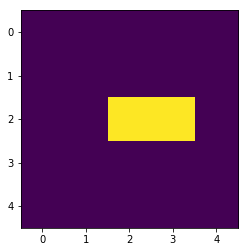

In [34]:
patch_test = torch.zeros((1,1,5,5))
patch_test[0,0,2,2] = 1
patch_test[0,0,2,3] = 1
patches_log = do_log(patch_test)
dxdy = soft_argmax_2d(patches_log, normalized_coordinates=False)
print("dxdy: ", dxdy)

plt.imshow(patch_test[0,0].numpy())

In [35]:
def test_soft_argmax(input):
    batch_size, channels, height, width = input.shape
#     x: torch.Tensor = input.view(batch_size, channels, -1)

    # compute softmax with max substraction trick
#     exp_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])
    exp_x = input
    eps = 1e-6
    exp_x_sum = torch.tensor(
        1.0) / (exp_x.sum(dim=-1, keepdim=True) + eps)

    # create coordinates grid
    pos_y, pos_x = create_meshgrid(input, self.normalized_coordinates)
    pos_x = pos_x.reshape(-1)
    pos_y = pos_y.reshape(-1)

    # compute the expected coordinates
    expected_y: torch.Tensor = torch.sum(
        (pos_y * exp_x) * exp_x_sum, dim=-1, keepdim=True)
    expected_x: torch.Tensor = torch.sum(
        (pos_x * exp_x) * exp_x_sum, dim=-1, keepdim=True)
    output: torch.Tensor = torch.cat([expected_x, expected_y], dim=-1)
    return output.view(batch_size, channels, 2)  # BxNx2

out_argmax = test_soft_argmax(patches)

NameError: name 'create_meshgrid' is not defined

## test labels 3D

In [73]:
from utils.d2s import DepthToSpace, SpaceToDepth

labels_2D = sample['labels_2D_gaussian']
space2depth = SpaceToDepth(8)
labels_3D = space2depth(labels_2D)

print("labels_3D: ", labels_3D.shape)
labels_sum = labels_3D[2].sum(dim=0)
print("labels_3D sum: ", labels_sum.shape)
print("labels_3D sum: ", labels_sum)

labels_3D:  torch.Size([16, 64, 15, 20])
labels_3D sum:  torch.Size([15, 20])
labels_3D sum:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8863, 0.0824, 0.0000, 0.0000,
         0.9843, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.9804, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.8824, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7882, 0.0275, 0.0000, 0.0000, 0.9961, 0.0000,
         0.0000, 0.0980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.9882, 0.0000, 0.0000, 0.1608, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

## test on train_set

## test residual map

In [ ]:
# syn
# labels_warped_res = sample['labels_res']
# warped_labels = sample['labels_2D']
# warped_img = sample['image']

# coco
labels_warped_res = sample['warped_res']
warped_labels = sample['warped_labels']
warped_img = sample['warped_img']

In [ ]:
img_id = 0

print("labels_warped_res: ", labels_warped_res.sum())
print("labels_warped_res: ", labels_warped_res.shape)
res_img = torch.norm(labels_warped_res, dim=1)
plt.imshow(toNumpy(res_img[img_id,:,:]))
plt.show()

# warped_labels
plt.imshow(toNumpy(warped_labels[img_id,0,:,:]))
plt.show()


# warped image
plt.imshow(toNumpy(warped_img[img_id,0,:,:]))
plt.show()



In [ ]:
def subpixel_loss(labels_2D, labels_res, pred_heatmap, batch_size, patch_size=7):
    """
    
    """
    # 
    def pts_to_bbox(points, patch_size):  
        """
        input: 
            points: (y, x)
        output:
            bbox: (x1, y1, x2, y2)
        """

        shift_l = patch_size / 2
        shift_r = patch_size - shift_l
#         bbox = torch.stack((points-shift_l, points+shift_r), dim=1)
        pts_l = points-shift_l
        pts_r = points+shift_r+1
        bbox = torch.stack((pts_l[:,1], pts_l[:,0], pts_r[:,1], pts_r[:,0]), dim=1)
        return bbox
        pass
    # roi pooling
    def _roi_pool(pred_heatmap, rois):
        from utils.roi_pool import RoIPool  # noqa: E402
        m = RoIPool(patch_size, 1.0)
        patches = m(pred_heatmap, rois.float())
        return patches
    
    # soft argmax
    def _soft_argmax(patches):
        from models.SubpixelNet import SubpixelNet as subpixNet
        dxdy = subpixNet.soft_argmax_2d(patches) # tensor [B, N, patch, patch]
        dxdy = dxdy.squeeze(1) # tensor [N, 2]
        return dxdy
    
    def print_var(points):
        print("points: ", points.shape)
        print("points: ", points)
        pass
   
    points = labels_2D[...].nonzero()
    labels_res = labels_res.transpose(1,2).transpose(2,3).unsqueeze(1)
    rois = pts_to_bbox(points[:,2:], patch_size)
    # filter out??
    rois = torch.cat((points[:,:1], rois), dim=1)
    points_res = labels_res[points[:,0],points[:,1],points[:,2],points[:,3],:]  # tensor [N, 2]
#     print_var(rois)
#     print_var(labels_res)
#     print_var(points)
#     print("points max: ", points.max(dim=0))
#     print_var(labels_2D)
#     print_var(points_res)
    

    patches = _roi_pool(pred_heatmap, rois)
    # get argsoft max
    dxdy = _soft_argmax(patches)

    loss = (points_res - dxdy)
#     loss = torch.norm(loss, p=2, dim=-1)
#     loss = loss.sum()
#     print("loss: ", loss)
    return patches, points_res, dxdy, loss
    pass

patch_size = 8
device='cuda:0'
outs = subpixel_loss(warped_labels.to(device), labels_warped_res.to(device), warped_img.to(device), 8, patch_size=patch_size)
patches, points_res, dxdy = outs[0], outs[1], outs[2]
for i in range(10):
    img_id = i
    def draw_center(patch):
        patch[...,3,3] = 1
        return patch
        
    print("softmax dxdy (y, x): ", dxdy[i])
    print("points_res (y, x): ", points_res[i])
#     plt.imshow(toNumpy(patches[img_id,0,:,:]))
    plt.imshow(toNumpy(draw_center(patches[img_id,0,:,:])))
    plt.show()

outs = subpixel_loss(warped_labels.to(device), labels_warped_res.to(device), res_img.unsqueeze(1).to(device), 8, patch_size=patch_size)
patches, points_res = outs[0], outs[1]
for i in range(10):
    img_id = i
    plt.imshow(toNumpy(patches[img_id,0,:,:]))
    plt.show()

In [ ]:
from utils.losses import subpixel_loss as loss_f
loss = loss_f(warped_labels.to(device), labels_warped_res.to(device), warped_labels.to(device), patch_size=11)
print("loss: ", loss)

In [ ]:
from utils.losses import subpixel_loss_no_argmax as loss_f
loss = loss_f(warped_labels.to(device), labels_warped_res.to(device), warped_labels.to(device), patch_size=11)
print("loss: ", loss)

In [ ]:
def get_model(path, name):
    mod = __import__('{}'.format(path), fromlist=[''])
    return getattr(mod, name)
get_model('utils.losses', 'subpixel_loss_no_argmax')

In [ ]:
from models.SubpixelNet import SubpixelNet
net = SubpixelNet(subpixel_channel=1)

### Test predicting flow on pixels

In [ ]:
print("labels_2D: ", labels_2D.shape)
print("labels_2D sum: ", labels_2D.sum())
print("warped_img: ", warped_img.shape)
img_warp = warped_img

In [ ]:
# extract the patches from labels 
label_idx = labels_2D[...].nonzero()
from utils.losses import extract_patches
patches = extract_patches(label_idx.to(device), img_warp.to(device), patch_size=32) # tensor [N, patch_size, patch_size]
# patches = extract_patches(label_idx.to(device), labels_2D.to(device), patch_size=15) # tensor [N, patch_size, patch_size]
print("patches: ", patches.shape)

def label_to_points(labels_res, points):
    labels_res = labels_res.transpose(1,2).transpose(2,3).unsqueeze(1)
    points_res = labels_res[points[:,0],points[:,1],points[:,2],points[:,3],:]  # tensor [N, 2]
    return points_res
    
points_res = label_to_points(labels_warped_res, label_idx)
print("points_res: ", points_res.shape)

for i in range(10):
    img_id = i
    plt.imshow(toNumpy(patches[img_id,0,:,:]))
    plt.show()

### Testing

In [ ]:
from utils.loader import get_module
train_model_frontend = get_module('', 'Train_model_subpixel')

In [ ]:
'{}.{}'.format('path', 'name')
import importlib
name = 'Train_model_subpixel'
mod = importlib.import_module(name)
getattr(mod, name)

## Visualize warped images (for joint training)

In [ ]:
# entries = ['image', 'labels_2D', 'valid_mask', 'overlay']
# entries = ['warped_img', 'warped_labels', 'warped_valid_mask', 'overlay']
entries = ['image', 'warped_img']
cols = len(entries)
scale = 5


In [ ]:
# show images
images_num = config['model']['batch_size']
col_row_ratio = 2
iter_max = 2
rows = images_num + 1

task_folder = ['matching']
print("load training samples")
for it, sample in enumerate(train_loader):
    # break if max iteration
    print("iter: ", it)
    
    if it > iter_max:
        print(list(sample))
        break
    plt.figure(figsize=(cols*col_row_ratio*scale, rows*scale))    
    count = 1   
    for i in range(images_num):
        for j in range(cols):
    #         exp_path = Path(base_path, folder[j], prediction, task_folder[0])
    #         path = exp_path / (str(i) + 'm.png')
    #         image = load_as_float(path)
#             print(entries[j])

            if entries[j] == 'overlay':
                img, labels_2D, mask_2D = sample[entries[0]], sample[entries[1]], sample[entries[2]]
                image = img_overlap(toNumpy(1 - mask_2D[i,:,:,:]), 
                    toNumpy(labels_2D[i, :, :, :]), toNumpy(img[i, :, :, :]))
            else:
                image = sample[entries[j]][i,0,:,:]
                image = image.numpy()
#                 print("image: ", image.shape)
#             print("count: ", count)
#             print("rows: ", rows)
#             print("cols: ", cols)
            plt.subplot(rows, cols, count)
            count += 1
            
            plt.axis('off')
            plt.title(entries[j] + '/' + str(i))
#             print("image: ", image)
            plt.imshow(image, cmap='gray')
            plt.tight_layout()
    plt.show()

In [ ]:
print("load validation samples")
for it, sample in enumerate(val_loader):
    # break if max iteration
    print("iter: ", it)
    
    if it > iter_max:
        print(list(sample))
        break
    plt.figure(figsize=(cols*col_row_ratio*scale, rows*scale))    
    count = 1   
    for i in range(images_num):
        for j in range(cols):
    #         exp_path = Path(base_path, folder[j], prediction, task_folder[0])
    #         path = exp_path / (str(i) + 'm.png')
    #         image = load_as_float(path)
#             print(entries[j])

            if entries[j] == 'overlay':
                img, labels_2D, mask_2D = sample[entries[0]], sample[entries[1]], sample[entries[2]]
                image = img_overlap(toNumpy(1 - mask_2D[i,:,:,:]), 
                    toNumpy(labels_2D[i, :, :, :]), toNumpy(img[i, :, :, :]))
            else:
                image = sample[entries[j]][i,0,:,:]
                image = image.numpy()
#                 print("image: ", image.shape)
#             print("count: ", count)
#             print("rows: ", rows)
#             print("cols: ", cols)
            plt.subplot(rows, cols, count)
            count += 1
            
            plt.axis('off')
            plt.title(entries[j] + '/' + str(i))
#             print("image: ", image)
            plt.imshow(image, cmap='gray')
            plt.tight_layout()
    plt.show()

## Visualize images w/o homography augmentation

In [ ]:
# entries = ['image', 'labels_2D', 'valid_mask', 'overlay']
entries = ['warped_img', 'warped_labels', 'warped_valid_mask', 'overlay']
cols = len(entries)
scale = 10


In [ ]:
# show images
count = 1
images_num = 2
col_row_ratio = 3
rows = images_num
plt.figure(figsize=(cols*col_row_ratio*scale, rows*scale))

task_folder = ['matching']
for i in range(images_num):
    for j in range(cols):
#         exp_path = Path(base_path, folder[j], prediction, task_folder[0])
#         path = exp_path / (str(i) + 'm.png')
#         image = load_as_float(path)
        print(entries[j])

        if entries[j] == 'overlay':
            img, labels_2D, mask_2D = sample[entries[0]], sample[entries[1]], sample[entries[2]]
            image = img_overlap(toNumpy(1 - mask_2D[i,:,:,:]), 
                toNumpy(labels_2D[i, :, :, :]), toNumpy(img[i, :, :, :]))
        else:
            image = sample[entries[j]][i,0,:,:]
            image = image.numpy()
        plt.subplot(rows, cols, count)
        count += 1
        plt.axis('off')
        plt.title(entries[j] + '/' + str(i))
        plt.imshow(image, cmap='gray')
        plt.tight_layout()
plt.show()

In [ ]:
mask_2D.shape

## Homography Adaptation

In [ ]:
# data loading
from utils.loader import dataLoader_test as dataLoader
# data = dataLoader(config, dataset='hpatches')
export_task = config['data']['export_folder']

data = dataLoader(config, dataset=task, export_task=export_task)
test_set, test_loader = data['test_set'], data['test_loader']


In [ ]:
# @torch.no_grad()
from tqdm import tqdm
from utils.utils import img_overlap, toNumpy

device = 'cpu'

count = 1
images_num = 2
col_row_ratio = 1
rows = 10
cols = 10
scale = 5
iter_max = 0
plt.figure(figsize=(cols*col_row_ratio*scale, rows*scale))
plot_inputs = True

for i, sample in tqdm(enumerate(test_loader)):
    img, mask_2D = sample['image'], sample['valid_mask']
    img = img.transpose(0,1)
    img_2D = img.numpy().squeeze()
    mask_2D = mask_2D.transpose(0,1)
    mask_2D_numpy = mask_2D.numpy()

    inv_homographies, homographies = sample['homographies'], sample['inv_homographies']
    img, mask_2D, homographies, inv_homographies = img.to(device), mask_2D.to(device), \
                                                   homographies.to(device), inv_homographies.to(device)
    
    def plotImg(rows, cols, count, image, name=''):
        plt.subplot(rows, cols, count)
        count += 1

        plt.axis('off')
        plt.title(name + '/' + str(i))
        print("image: ", image.shape)
        plt.imshow(image)
        plt.tight_layout()
    print("img_2D: ", img_2D.shape)
    print("mask_2D: ", mask_2D.shape)
    
    if plot_inputs:
        for j in range(img.shape[0]):
            image = img_overlap((1 - mask_2D_numpy[j,:,:]), 
                    np.zeros_like(img_2D[j,:,:]), img_2D[j,:,:])
            plotImg(rows, cols, count, image.transpose([1,2,0]),'warped-')
            count += 1
    def homography_adaptation(heatmap, inv_homographies, mask_2D, config):
        from utils.utils import inv_warp_image_batch

        ## multiply heatmap with mask_2D
        heatmap = heatmap*mask_2D

        heatmap = inv_warp_image_batch(heatmap, inv_homographies[0,:,:,:], device=device, mode='bilinear')

        ##### check
        mask_2D = inv_warp_image_batch(mask_2D, inv_homographies[0,:,:,:], device=device, mode='bilinear')
        heatmap = torch.sum(heatmap, dim=0)
        mask_2D = torch.sum(mask_2D, dim=0)
        return heatmap/mask_2D
    pass
    image = homography_adaptation(img, inv_homographies, mask_2D, config)
    print("image: ", image.shape)
#     plotImg(rows, cols, count, toNumpy(image), name='')
    
    if i>iter_max: break

In [ ]:
# plotImg(rows, cols, count, toNumpy(image).squeeze(), name='')
image_np = toNumpy(image).squeeze()
plt.imshow(image_np)

In [ ]:
image

In [ ]:
image

In [ ]:
m = mask_2D_numpy[j,:,:]
image = img_overlap((1 - mask_2D_numpy[j,:,:]), 
        np.zeros_like(img_2D[j,:,:]), img_2D[j,:,:])
print("m: ", m.shape)
print("image: ", image.shape)
plt.imshow(image.transpose([1,2,0]))
plt.show()



In [ ]:
# show homography adaptation images
# show images
images_num = config['data']['homography_adaptation']['num']
col_row_ratio = 2
iter_max = 20
rows = images_num + 1

task_folder = ['matching']
print("load training samples")
for it, sample in enumerate(train_loader):
    # break if max iteration
    print("iter: ", it)
    
    if it > iter_max:
        print(list(sample))
        break
    plt.figure(figsize=(cols*col_row_ratio*scale, rows*scale))    
    count = 1   
    for i in range(images_num):
        for j in range(cols):
    #         exp_path = Path(base_path, folder[j], prediction, task_folder[0])
    #         path = exp_path / (str(i) + 'm.png')
    #         image = load_as_float(path)
#             print(entries[j])

            if entries[j] == 'overlay':
                img, labels_2D, mask_2D = sample[entries[0]], sample[entries[1]], sample[entries[2]]
                image = img_overlap(toNumpy(1 - mask_2D[i,:,:,:]), 
                    toNumpy(labels_2D[i, :, :, :]), toNumpy(img[i, :, :, :]))
            else:
                image = sample[entries[j]][i,0,:,:]
                image = image.numpy()
#                 print("image: ", image.shape)
#             print("count: ", count)
#             print("rows: ", rows)
#             print("cols: ", cols)
            plt.subplot(rows, cols, count)
            count += 1
            
            plt.axis('off')
            plt.title(entries[j] + '/' + str(i))
#             print("image: ", image)
            plt.imshow(image, cmap='gray')
            plt.tight_layout()
    plt.show()

In [ ]:
try:
    path = config['pretrained']
    print('==> Loading pre-trained network.')
    print('path: ', path)
    # This class runs the SuperPoint network and processes its outputs.

    fe = SuperPointFrontend_torch(weights_path=path,
                            nms_dist=nms_dist,
                            conf_thresh=conf_thresh,
                            nn_thresh=nn_thresh,
                            cuda=False,
                            device=device)
    print('==> Successfully loaded pre-trained network.')

    fe.net_parallel()
    print(path)
    # save to files
    save_file = save_output / "export.txt"
    with open(save_file, "a") as myfile:
        myfile.write("load model: " + path + '\n')
except Exception:
    pass